In [1]:
import torch
import torch.nn as nn
from torch.nn import GRU, Linear, LSTM, Conv1d
from scipy.io import wavfile
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import sys
import math

In [2]:
# Training parameters
DI_path = "ht1-input.wav"
target_path = "ht1-target.wav"
# DI_path = "DI.wav"
# target_path = "target.wav"
train_val_ratio = 0.9
epochs = 100
batch_size = 500
window_size = 32768
sequence_size = 256
lr = 0.001
name = 'ht1'

In [3]:
# wavfile utils
def read_wav_file(path, normalize=True):
    rate, sig = wavfile.read(path)
    print("Read {} with {} samples, rate is {}Hz".format(path, len(sig), rate))
    sig = np.float32(sig)
    if normalize == True:
        return rate, (sig - np.mean(sig)) * 2 / (sig.max() - sig.min()) # Normalized
    return rate, sig

def write_wav_file(path, sig, rate, normalized=True, bitwidth=16):
    if normalized == True:
        _range = float(np.power(2, bitwidth-1))
        for i in range(len(sig)):
            sig[i] *= _range
    wavfile.write(path, rate, sig.astype(np.int16))

def window_array(input, window_size):
    input_len = len(input)
    window_cnt = math.floor(input_len / window_size)
    window = np.zeros((window_cnt, window_size))
    for i in range(window_cnt):
        window[i] = input[i*window_size : i*window_size+window_size]
    return window.reshape(window_cnt, window_size).astype(np.float32)

Read ht1-input.wav with 14994001 samples, rate is 44100Hz
Read ht1-target.wav with 14994001 samples, rate is 44100Hz


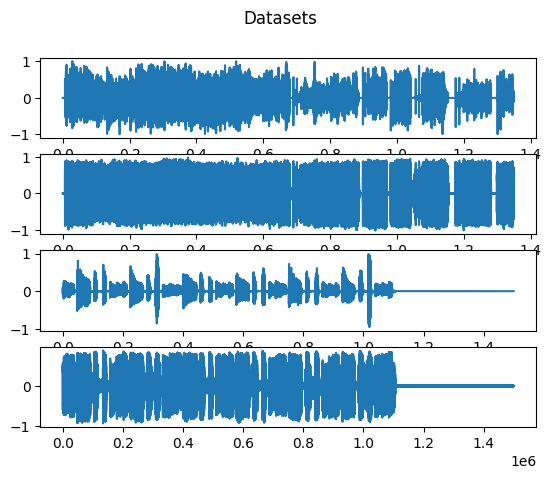

Using GPU for training


In [4]:
# Load dataset
_, DI_dataset = read_wav_file(DI_path)
_, target_dataset = read_wav_file(target_path)
# Verify dataset length
if len(DI_dataset) != len(target_dataset):
    print("DI length and target length is not equal")
    sys.exit()
trainset_size = int(len(DI_dataset)*train_val_ratio)
input_trainset = DI_dataset[:trainset_size]
input_valset = DI_dataset[trainset_size:]
target_trainset = target_dataset[:trainset_size]
target_valset = target_dataset[trainset_size:]
# Plot original datasets
fig, ax = plt.subplots(4)
fig.suptitle("Datasets")
ax[0].plot(input_trainset)
ax[1].plot(target_trainset)
ax[2].plot(input_valset)
ax[3].plot(target_valset)
plt.show()

# Split datasets to frames
input_trainset = window_array(input_trainset, window_size)
input_valset = window_array(input_valset, window_size)
target_trainset = window_array(target_trainset, window_size)
target_valset = window_array(target_valset, window_size)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using GPU for training")
else:
    device = torch.device("cpu")
    print("Using CPU for training")

input_trainset = torch.from_numpy(input_trainset).to(device)
input_valset = torch.from_numpy(input_valset).to(device)
target_trainset = torch.from_numpy(target_trainset).to(device)
target_valset = torch.from_numpy(target_valset).to(device)

In [5]:
class DNN(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc1 = Linear(input_size, 1024)
        self.fc2 = Linear(1024, 512)
        self.fc3 = Linear(512, output_size)

    def forward(self, input):
        fc1_out = self.fc1(input)
        fc1_out = F.relu(fc1_out)
        fc2_out = self.fc2(fc1_out)
        fc2_out = F.relu(fc2_out)
        output = self.fc3(fc2_out)
        output = F.tanh(output)
        return output

model = DNN(sequence_size, sequence_size)
model.to(device)
print(model)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

DNN(
  (fc1): Linear(in_features=256, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
)


In [6]:
def adjust_lr(optimizer, epoch, start_lr):
    lr = start_lr * (0.5 ** (epoch // 20))
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
# Training
for i in range(epochs):
    # Shuffle data
    shuffle = torch.randperm(input_trainset.shape[0])
    input_trainset = input_trainset[shuffle]
    target_trainset = target_trainset[shuffle]
    # adjust_lr(optimizer, i, lr)
    loss = 0
    for j in range(math.ceil(input_trainset.shape[0] / batch_size)):
        input_batch = input_trainset[j*batch_size : j*batch_size+batch_size, :]
        target_batch = target_trainset[j*batch_size : j*batch_size+batch_size, :]
        batch_loss = 0
        for k in range(math.ceil(input_batch.shape[1] / sequence_size)):
            optimizer.zero_grad()
            pred = model(input_batch[:, k*sequence_size : k*sequence_size+sequence_size])
            single_loss = loss_function(pred, target_batch[:, k*sequence_size : k*sequence_size+sequence_size])
            single_loss.backward()
            optimizer.step()
            batch_loss += single_loss
        batch_loss /= (k + 1)
        loss += batch_loss
    loss /= (j + 1)
    if i % 25 == 0:
        print("Epoch {}, loss {}".format(i, loss))
torch.save(model, name+".pth")

Epoch 0, loss 0.08163248002529144
Epoch 25, loss 0.06361053138971329
Epoch 50, loss 0.0629601925611496
Epoch 75, loss 0.06271776556968689
Epoch 100, loss 0.06258979439735413
Epoch 125, loss 0.06251596659421921
Epoch 150, loss 0.06248548999428749
Epoch 175, loss 0.062442466616630554
Epoch 200, loss 0.06240934133529663
Epoch 225, loss 0.06238463148474693


Val loss 5.015901565551758


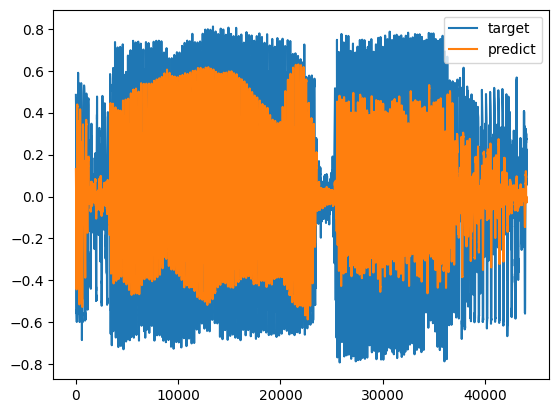

In [7]:
# Eval
pred = torch.empty_like(input_valset)
model.eval()
loss = 0
for i in range(math.ceil(input_valset.shape[0] / batch_size)):
    input_batch = input_valset[i*batch_size : i*batch_size+batch_size, :]
    val_batch = target_valset[i*batch_size : i*batch_size+batch_size, :]
    pred_batch = torch.empty_like(input_batch)
    for k in range(math.ceil(input_batch.shape[1] / sequence_size)):
        pred_batch[:, k*sequence_size : k*sequence_size+sequence_size] = model(input_batch[:, k*sequence_size : k*sequence_size+sequence_size])
        loss += loss_function(pred_batch[:, k*sequence_size : k*sequence_size+sequence_size], val_batch[:, k*sequence_size : k*sequence_size+sequence_size])
    pred[i*batch_size : i*batch_size+batch_size] = pred_batch
loss /= (i + 1)
print("Val loss {}".format(loss))

# Plot target and pred
pred = torch.flatten(pred).detach().to(torch.device("cpu")).numpy()
target = torch.flatten(target_valset).detach().to(torch.device("cpu")).numpy()
origin = torch.flatten(input_valset).detach().to(torch.device("cpu")).numpy()
plt.figure(2)
plt.plot(target[:44100], label="target")
plt.plot(pred[:44100], label="predict")
plt.legend()
plt.show()

write_wav_file("pred.wav", pred, 44100)
write_wav_file("target.wav", target, 44100)